In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [140]:
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean, cosine
from collections import defaultdict
import random
import operator

In [3]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from importlib import reload
from data_cleaning import data_cleaning as dc
from models import clustering as cl

In [60]:
def rmse(yhat, y):
    ''' Return root mean squared error of a set of predictions '''
    return np.sqrt(((yhat - y)**2).mean())

In [8]:
contracts = dc.clean_contracts_data()

In [9]:
contracts.shape

(1762, 28)

In [10]:
df = pd.read_csv('../data/thur_data.csv')

In [11]:
df.shape

(1170, 209)

In [12]:
df.drop('Position', axis=1, inplace=True)
df.set_index(df['Season_Player'], inplace=True)

In [15]:
#extra feature engineering
df['Giveaways/60'] = (df['Giveaways'] / df['TOI']) * 60
df['mean Giveaways/60'] = (df['sum Giveaways'] / df['sum TOI']) * 60
df['Takeaways/60'] = (df['Takeaways'] / df['TOI']) * 60
df['mean Takeaways/60'] = (df['sum Takeaways'] / df['sum TOI']) * 60
df['Shots Blocked/60'] = (df['Shots Blocked']/df['TOI']) * 60
df['mean Shots Blocked/60'] = (df['sum Shots Blocked'] / df['sum TOI']) * 60
df['mean Total Points/60'] = (df['sum Total Points']/df['sum TOI']) * 60
df['Total Points/60'] = (df['Total Points']/df['TOI']) * 60
df['Goals/60'] = (df['Goals']/df['TOI']) * 60
df['mean Goals/60'] = (df['sum Goals']/df['sum TOI']) * 60
df['Shots/60'] = (df['Shots']/df['TOI']) * 60
df['mean Shots/60'] = (df['sum Shots']/df['sum TOI']) * 60
df['Hits/60'] = (df['Hits']/df['TOI']) * 60
df['mean Hits/60'] = (df['sum Hits']/df['sum TOI']) * 60
df['PIM/60'] = (df['PIM']/df['TOI']) * 60
df['mean PIM/60'] = (df['sum PIM']/df['sum TOI']) * 60
df['Penalties Drawn/60'] = (df['Penalties Drawn']/df['TOI']) * 60
df['mean Penalties Drawn/60'] = (df['sum Penalties Drawn']/df['sum TOI']) * 60
df['mean Faceoffs pct'] = (df['sum Faceoffs Won'] / df['sum Faceoffs Lost'])

In [16]:
df.shape

(1170, 227)

In [43]:
to_save = df.drop(['player_id', 'first_name', 'last_name', 'birthdate', 'team_id', 
                 'team_name', 'active', 'signing_date', 'signing_team', 'contract_level', 
                   'contract_type', 'contract_end', 'ufa_year', '3yr Season_Player', 
                   'skater', 'forward', 'expiry_status', 'season', 'year_match'
], axis = 1)

In [44]:
to_save.shape

(1170, 208)

In [78]:
to_save.rename({'3yr Off.\xa0Zone Starts/60': '3yr Off. Zone Starts/60',
 '3yr Neu.\xa0Zone Starts/60': '3yr Neu. Zone Starts/60',
 '3yr Def.\xa0Zone Starts/60': '3yr Def. Zone Starts/60',
 '3yr On\xa0The\xa0Fly Starts/60': '3yr On The Fly Starts/60',
 '3yr Off.\xa0Zone Start %': '3yr Off. Zone Start %',
 '3yr Off.\xa0Zone Faceoffs/60': '3yr Off. Zone Faceoffs/60',
 '3yr Neu.\xa0Zone Faceoffs/60': '3yr Neu. Zone Faceoffs/60',
 '3yr Def.\xa0Zone Faceoffs/60': '3yr Def. Zone Faceoffs/60',
 '3yr Off.\xa0Zone Faceoff %': '3yr Off. Zone Faceoff %'}, axis = 1, inplace=True)

In [79]:
to_save.to_csv('../data/data_for_model.csv')

In [399]:
test = pd.read_csv('../data/data_for_model.csv', index_col='Season_Player')

In [81]:
test.head()

,position,cap_hit,length,total_value,Player,signing_year,signing_age,signing_year_cap,cap_pct,signing_status,...,mean Goals/60,Shots/60,mean Shots/60,Hits/60,mean Hits/60,PIM/60,mean PIM/60,Penalties Drawn/60,mean Penalties Drawn/60,mean Faceoffs pct
Season_Player,,,,,,,,,,,,,,,,,,,,,
2014 Francois Beauchemin,Defense,4500000,3,13500000,Francois Beauchemin,2015,35.0,71400000,6.30,UFA,...,0.300126,4.535147,4.058853,4.329004,4.258938,1.978973,1.529216,0.206143,0.271543,inf
2016 Francois Beauchemin,Defense,1000000,1,1700000,Francois Beauchemin,2017,37.0,75000000,1.33,UFA,...,0.274045,4.544490,4.213435,2.513240,2.923142,1.101694,1.347386,0.240996,0.228370,inf
2015 Brent Burns,Defense,8000000,8,64000000,Brent Burns,2016,31.0,73000000,10.96,UFA,...,0.754954,9.986562,9.642827,2.857345,4.506849,1.499399,1.738683,0.480939,0.571935,0.885714
2017 Zdeno Chara,Defense,5000000,1,5000000,Zdeno Chara,2018,41.0,79500000,6.29,UFA,...,0.291608,5.167619,4.912471,5.059960,4.542353,2.153174,2.130981,0.502407,0.616863,0.000000
2015 Jason Chimera,Left Wing,2250000,2,4500000,Jason Chimera,2016,37.0,73000000,3.08,UFA,...,0.738436,8.592631,7.525010,5.363885,6.593175,1.145684,1.916416,0.624919,0.843926,0.872549


In [400]:
df = test.drop([
    'Player', 'Season_Player.1'
], axis=1)

In [401]:
df.shape

(1170, 206)

In [84]:
df.columns[:20]

Index(['position', 'cap_hit', 'length', 'total_value', 'signing_year',
       'signing_age', 'signing_year_cap', 'cap_pct', 'signing_status',
       'Season', 'GP', 'TOI', 'Goals', 'Total Assists', 'First Assists',
       'Second Assists', 'Total Points', 'Shots', 'iCF', 'iFF'],
      dtype='object')

In [402]:
#specify target column labels
target_labels = [
    'cap_hit', 'cap_pct', 'length', 'total_value'
]

In [403]:
#split into forwards and defense
forwards = df[df.position != 'Defense']
defense = df[df.position == 'Defense']
forwards.shape, defense.shape

((762, 206), (408, 206))

In [404]:
#drop columns that aren't targets or potential features
forwards.drop(['position', 'Season'], axis=1, inplace=True)
defense.drop(['position', 'Season'], axis=1, inplace=True)

/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [223]:
#defense clustering
Xd = defense[['mean Total Points', 'mean Total Points/60', 'TOI/GP', '3yr CF/60 Rel', '3yr CA/60 Rel',
              '3yr Off. Zone Starts/60', '3yr Def. Zone Starts/60', 'mean Shots Blocked/60']]
yd = defense[['length', 'cap_hit', 'cap_pct']]

ss = StandardScaler()
Xds = ss.fit_transform(Xd)
dkm = KMeans(n_clusters = 3)
dclus = dkm.fit_transform(Xds)
#create a cluster feature column
Xd['cluster'] = dkm.labels_
defense['cluster'] = dkm.labels_

dclusts = []
dcmeans = []
for i in range(dkm.n_clusters):
    dclusts.append(Xd[dkm.labels_ == i].drop('cluster', axis=1))
    dcmeans.append(dclusts[i].mean(axis=0))

/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [224]:
#forward clustering
Xf = forwards[['mean Total Points', 'mean Total Points/60', 'mean Goals/60', '3yr CF/60 Rel', '3yr CA/60 Rel',
              '3yr Off. Zone Starts/60', '3yr Def. Zone Starts/60', 'mean Shots Blocked/60', 'TOI/GP']]
yf = forwards[['length', 'cap_hit', 'cap_pct']]

ss = StandardScaler()
Xfs = ss.fit_transform(Xf)

fkm = KMeans(n_clusters = 4)
fclus = fkm.fit_transform(Xfs)
Xf['cluster'] = fkm.labels_
forwards['cluster'] = fkm.labels_

fclusts = []
fcmeans = []
for i in range(fkm.n_clusters):
    fclusts.append(Xf[fkm.labels_ == i].drop('cluster', axis=1))
    fcmeans.append(fclusts[i].mean(axis=0))

/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [408]:
list(forwards.columns)

['cap_hit',
 'length',
 'total_value',
 'signing_year',
 'signing_age',
 'signing_year_cap',
 'cap_pct',
 'signing_status',
 'GP',
 'TOI',
 'Goals',
 'Total Assists',
 'First Assists',
 'Second Assists',
 'Total Points',
 'Shots',
 'iCF',
 'iFF',
 'iSCF',
 'iHDCF',
 'Rush Attempts',
 'Rebounds Created',
 'PIM',
 'Total Penalties',
 'Minor',
 'Major',
 'Misconduct',
 'Penalties Drawn',
 'Giveaways',
 'Takeaways',
 'Hits',
 'Hits Taken',
 'Shots Blocked',
 'Faceoffs Won',
 'Faceoffs Lost',
 'Season_index',
 'sum GP',
 'sum TOI',
 'sum Goals',
 'sum Total Assists',
 'sum First Assists',
 'sum Second Assists',
 'sum Total Points',
 'sum Shots',
 'sum iCF',
 'sum iFF',
 'sum iSCF',
 'sum iHDCF',
 'sum Rush Attempts',
 'sum Rebounds Created',
 'sum PIM',
 'sum Total Penalties',
 'sum Minor',
 'sum Major',
 'sum Misconduct',
 'sum Penalties Drawn',
 'sum Giveaways',
 'sum Takeaways',
 'sum Hits',
 'sum Hits Taken',
 'sum Shots Blocked',
 'sum Faceoffs Won',
 'sum Faceoffs Lost',
 'mean GP',
 

In [405]:
forwards['Off. Zone Start %'].replace(['-'], [int(0)], inplace=True)
forwards['3yr Off. Zone Start %'].replace(['-'], [int(0)], inplace=True)
defense['Off. Zone Start %'].replace(['-'], [int(0)], inplace=True)
defense['3yr Off. Zone Start %'].replace(['-'], [int(0)], inplace=True)

/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5886: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [313]:
reload(cl)

<module 'models.clustering' from '/Users/colinshanahan/galvanize/nhl-contract-predictions/models/clustering.py'>

In [406]:
forwards.signing_status = forwards.signing_status.apply(lambda x: 1 if 'UFA' else 0)
defense.signing_status = defense.signing_status.apply(lambda x: 1 if 'UFA' else 0)

/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

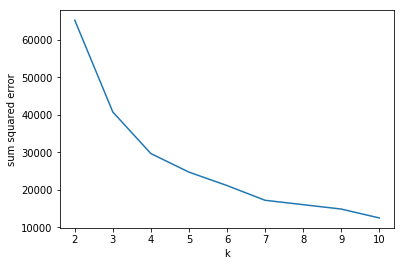

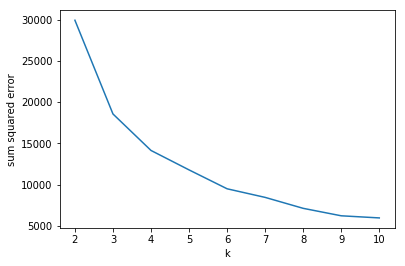

In [418]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
forwards[['Off. Zone Start %', '3yr Off. Zone Start %']] = imp.fit_transform(forwards[['Off. Zone Start %', '3yr Off. Zone Start %']])
defense[['Off. Zone Start %', '3yr Off. Zone Start %']] = imp.fit_transform(defense[['Off. Zone Start %', '3yr Off. Zone Start %']])

Xf = forwards[['mean Total Points/60', 'mean Goals/60',
              '3yr Off. Zone Start %', 'TOI/GP']]
Xd = defense[['mean Total Points/60', 'mean Goals/60',
              '3yr Off. Zone Start %', 'TOI/GP']]



cl.plot_k_sse(Xf.values , 2, 10)
cl.plot_k_sse(Xd.values, 2, 10)

In [429]:
#defense clustering
Xd = defense[['mean Total Points/60', '3yr Off. Zone Start %', 'TOI/GP']]
yd = defense[['length', 'cap_hit', 'cap_pct']]

ss = StandardScaler()
Xds = ss.fit_transform(Xd)
dkm = KMeans(n_clusters = 3)
dclus = dkm.fit_transform(Xds)
#create a cluster feature column
Xd['cluster'] = dkm.labels_
defense['cluster'] = dkm.labels_

dclusts = []
dcmeans = []
for i in range(dkm.n_clusters):
    dclusts.append(Xd[dkm.labels_ == i].drop('cluster', axis=1))
    dcmeans.append(dclusts[i].mean(axis=0))

/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [430]:
#forward clustering
Xf = forwards[['mean Total Points/60', '3yr Off. Zone Start %', 'TOI/GP']]
yf = forwards[['length', 'cap_hit', 'cap_pct']]

ss = StandardScaler()
Xfs = ss.fit_transform(Xf)

fkm = KMeans(n_clusters = 4)
fclus = fkm.fit_transform(Xfs)
Xf['cluster'] = fkm.labels_
forwards['cluster'] = fkm.labels_

fclusts = []
fcmeans = []
for i in range(fkm.n_clusters):
    fclusts.append(Xf[fkm.labels_ == i].drop('cluster', axis=1))
    fcmeans.append(fclusts[i].mean(axis=0))

/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


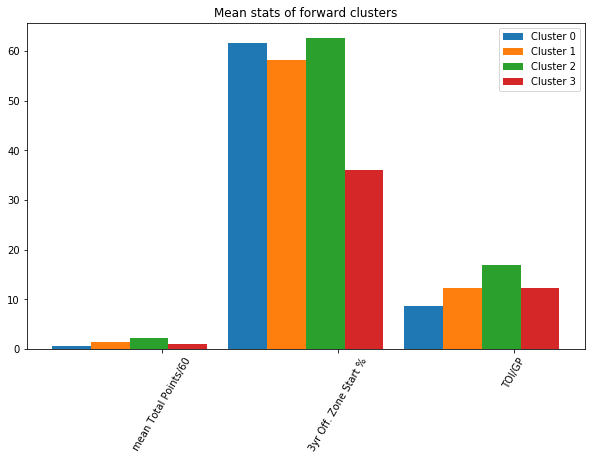

In [450]:
#plot forward clusters
w = 0.22
idx = fcmeans[0].index

xx = np.arange(len(idx))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

#for i in fcmeans:
ax.bar(x = xx - 2*w, height = fcmeans[0], width = w, label = 'Cluster 0')
ax.bar(x = xx - w, height = fcmeans[1], width = w, label = 'Cluster 1')
ax.bar(x = xx, height = fcmeans[2], width = w, label = 'Cluster 2')
ax.bar(x = xx + w, height = fcmeans[3], width = w, label = 'Cluster 3')

ax.set_xticks(xx + w/3)
ax.set_xticklabels(idx, rotation = 60)


ax.legend()

ax.set_title('Mean stats of forward clusters')
plt.show()

In [432]:
for i in fclusts:
    print(i.shape)

(129, 3)
(215, 3)
(208, 3)
(210, 3)


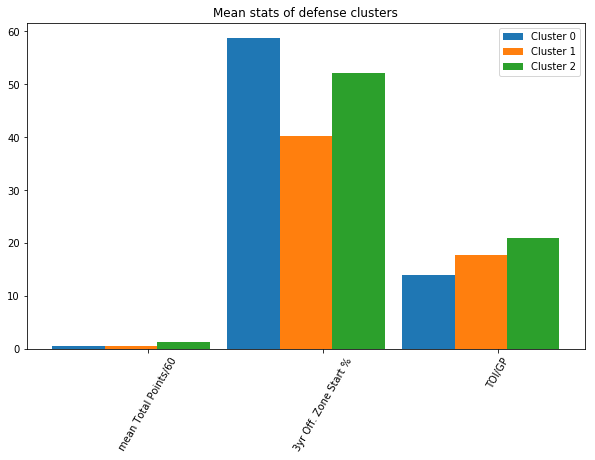

In [449]:
#plot the defensive clusters
w = 0.3
idx = dcmeans[0].index

xx = np.arange(len(idx))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.bar(x = xx - w, height = dcmeans[0], width = w, label = 'Cluster 0')
ax.bar(x = xx, height = dcmeans[1], width = w, label = 'Cluster 1')
ax.bar(x = xx + w, height = dcmeans[2], width = w, label = 'Cluster 2')
#ax.bar(x = xx + w, height = dcmeans[3], width = w, label = 'Cluster 3')
ax.set_xticks(xx + w/3)
ax.set_xticklabels(idx, rotation = 60)


ax.legend()

ax.set_title('Mean stats of defense clusters')
plt.show()

In [434]:
for i in dclusts:
    print(i.shape)

(160, 3)
(166, 3)
(82, 3)


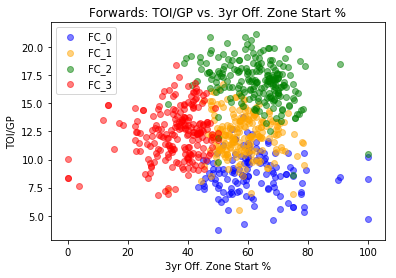

In [447]:
xax = '3yr Off. Zone Start %'
yax = 'TOI/GP'
alpha=a

plt.scatter(forwards[forwards.cluster == 0][xax], 
            forwards[forwards.cluster == 0][yax], 
            color = 'b', label = 'FC_0', alpha=a)
plt.scatter(forwards[forwards.cluster == 1][xax], 
            forwards[forwards.cluster == 1][yax], 
            color = 'orange', label = 'FC_1', alpha=a)
plt.scatter(forwards[forwards.cluster == 2][xax], 
            forwards[forwards.cluster == 2][yax], 
            color = 'g', label = 'FC_2', alpha=a)
plt.scatter(forwards[forwards.cluster == 3][xax], 
            forwards[forwards.cluster == 3][yax], 
            color = 'r', label = 'FC_3', alpha=a)

plt.legend()
plt.xlabel(xax)
plt.ylabel(yax)
plt.title('Forwards: ' + yax + ' vs. ' + xax)

plt.show()

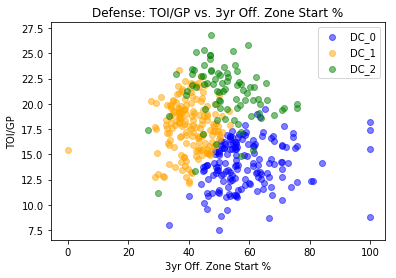

In [448]:
xax = '3yr Off. Zone Start %'
yax = 'TOI/GP'
a = 0.5

plt.scatter(defense[defense.cluster == 0][xax], 
            defense[defense.cluster == 0][yax], 
            color = 'b', label = 'DC_0', alpha=a)
plt.scatter(defense[defense.cluster == 1][xax], 
            defense[defense.cluster == 1][yax], 
            color = 'orange', label = 'DC_1', alpha=a)
plt.scatter(defense[defense.cluster == 2][xax], 
            defense[defense.cluster == 2][yax], 
            color = 'g', label = 'DC_2', alpha=a)


plt.legend()
plt.xlabel(xax)
plt.ylabel(yax)
plt.title('Defense: ' + yax + ' vs. ' + xax)

plt.show()

In [438]:
#Calculate RMSE for predicting each cluster on its mean cap hit
fmeancaphit = []
fyclusts = []
for x, i in enumerate(fclusts):
    cy = yf[fkm.labels_ == x]
    fyclusts.append(cy)
    print('RMSE for forwards cluster {} mean: ${}'
          .format(x, round(rmse(cy.cap_hit.mean(), cy.cap_hit))))
    print('Mean cap hit for forwards cluster {}: ${}\n'.format(x, round(cy.cap_hit.mean())))

dmeancaphit = []
dyclusts = []
for x, i in enumerate(dclusts):
    cy = yd[dkm.labels_ == x]
    dyclusts.append(cy)
    print('RMSE for defense cluster {} mean: ${}'
          .format(x, round(rmse(cy.cap_hit.mean(), cy.cap_hit))))
    print('Mean cap hit for defense cluster {}: ${}\n'.format(x, round(cy.cap_hit.mean())))

RMSE for forwards cluster 0 mean: $222817.0
Mean cap hit for forwards cluster 0: $701387

RMSE for forwards cluster 1 mean: $634751.0
Mean cap hit for forwards cluster 1: $1072302

RMSE for forwards cluster 2 mean: $2215228.0
Mean cap hit for forwards cluster 2: $4361481

RMSE for forwards cluster 3 mean: $889255.0
Mean cap hit for forwards cluster 3: $1230569

RMSE for defense cluster 0 mean: $440628.0
Mean cap hit for defense cluster 0: $819230

RMSE for defense cluster 1 mean: $1326284.0
Mean cap hit for defense cluster 1: $1868351

RMSE for defense cluster 2 mean: $2226912.0
Mean cap hit for defense cluster 2: $4442003



In [439]:

#combine forward and defensive clusters to get aggregate stats
clusts = fclusts + dclusts
yclusts = fyclusts + dyclusts

In [207]:
c = t_forwards[t_forwards.cluster == i].drop([
    'cap_hit',
     'length',
     'total_value',
     'signing_year',
     'signing_year_cap',
     'cap_pct',
     'signing_status', 'Season_index', 'cluster'
], axis=1)
c.dropna(axis=1, inplace=True)
clusts.append(c)
print(len(c.columns))

194


In [220]:
for co in forwards.columns:
    print(forwards[co].isnull().sum(), co)

0 cap_hit
0 length
0 total_value
0 signing_year
0 signing_age
0 signing_year_cap
0 cap_pct
0 signing_status
0 GP
0 TOI
0 Goals
0 Total Assists
0 First Assists
0 Second Assists
0 Total Points
0 Shots
0 iCF
0 iFF
0 iSCF
0 iHDCF
0 Rush Attempts
0 Rebounds Created
0 PIM
0 Total Penalties
0 Minor
0 Major
0 Misconduct
0 Penalties Drawn
0 Giveaways
0 Takeaways
0 Hits
0 Hits Taken
0 Shots Blocked
0 Faceoffs Won
0 Faceoffs Lost
0 Season_index
0 sum GP
0 sum TOI
0 sum Goals
0 sum Total Assists
0 sum First Assists
0 sum Second Assists
0 sum Total Points
0 sum Shots
0 sum iCF
0 sum iFF
0 sum iSCF
0 sum iHDCF
0 sum Rush Attempts
0 sum Rebounds Created
0 sum PIM
0 sum Total Penalties
0 sum Minor
0 sum Major
0 sum Misconduct
0 sum Penalties Drawn
0 sum Giveaways
0 sum Takeaways
0 sum Hits
0 sum Hits Taken
0 sum Shots Blocked
0 sum Faceoffs Won
0 sum Faceoffs Lost
0 mean GP
0 mean TOI
0 mean Goals
0 mean Total Assists
0 mean First Assists
0 mean Second Assists
0 mean Total Points
0 mean Shots
0 mean i

In [253]:
from sklearn.preprocessing import Imputer

In [365]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
t_forwards = imp.fit_transform(forwards)

ValueError: could not convert string to float: 'UFA'

In [442]:
clusts = []

t_forwards = forwards.replace(['-', ' - '], [0, 0])
t_defense = defense.replace(['-', ' - '], [0, 0])

obj_cols = ['GF% Rel',
'HDGF% Rel',
'MDCF% Rel',
'MDGF% Rel',
'LDGF% Rel',
'Off. Zone Faceoff %',
'3yr GF% Rel',
'3yr HDGF% Rel',
'3yr MDCF% Rel',
'3yr MDGF% Rel',
'3yr LDGF% Rel',
]

for i in range(len(fclusts)):
    c = t_forwards[t_forwards.cluster == i].drop([
        'cap_hit',
         'length',
         'total_value',
         'signing_year',
         'signing_year_cap',
         'cap_pct',
         'Season_index', 'cluster', 
        'mean SH%','mean Faceoffs %', 'mean Faceoffs pct'
    ], axis=1)
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    c = imp.fit_transform(c)

    clusts.append(c)
    
    
for i in range(len(dclusts)):
    c = t_defense[t_defense.cluster == i].drop([
    'cap_hit',
     'length',
     'total_value',
     'signing_year',
     'signing_year_cap',
     'cap_pct',
     'Season_index', 'cluster', 
    'mean SH%','mean Faceoffs %', 'mean Faceoffs pct'
    ], axis=1)
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    c = imp.fit_transform(c)
    #c.drop(obj_cols, axis=1, inplace=True)
    #c = c.apply(lambda x: round(x, 2))
#     for col in c.columns:
#         c[col].fillna(c[col].median(), inplace=True)
    
#     for col in obj_cols:
#         c[col] = c[col].apply(float)
    
#    c.dropna(axis=1, how='any', inplace=True)
    clusts.append(c)
#    print(len(c.columns))

In [295]:
len(np.concatenate(best_preds))

178

In [443]:
#model evaluation on each cluster
X_trains, X_tests, y_trains, y_tests = [], [], [], []
# rfrmodels, knnmodels, rnrmodels = [], [], []
# linmodels = []
# adamodels = []
# grbmodels = []
# rfrpreds, linpreds, adapreds, grbpreds, knnpreds, rnrpreds = [], [], [], [], [], []
models = defaultdict()
preds = defaultdict(np.array)
y_len=0
r_term = 0
y_ordered = []

best_mods = []
best_preds = []

for idx, c in enumerate(clusts):
    rmse_list = defaultdict(float)
    temp_y = yclusts[idx]['cap_hit']
    X_train, X_test, y_train, y_test = train_test_split(c, temp_y
                                                        , test_size = 0.15)
    y_ordered.append(y_test)
    y_len += len(y_test)
    print('Cluster {} stats: \nCluster test size: {}'.format(idx, len(y_test)))
    print('Cluster train size: {}'.format(len(y_train)))
    print('Cluster train mean cap hit: ${}'.format(round(temp_y.mean(), r_term)))
    print('RMSE for predicting cluster mean: ${}\n'.format(round(rmse(temp_y.mean(), y_test), r_term)))
    
    models['pcm'] = 'Pick mean'
    preds['pcm'] = temp_y.mean()
    rmse_list['Pick cluster mean - pcm'] = round(rmse(temp_y.mean(), y_test), r_term)
    
    X_trains.append(X_train)
    X_tests.append(X_test)
    y_trains.append(y_train)
    y_tests.append(y_test)
    
    rfrmod = RandomForestRegressor()
    rfrmod.fit(X_train, y_train)
    #rfrmodels.append(rfrmod)
    rfrp = rfrmod.predict(X_test)
    #rfrpreds.append(rfrp)
    models['rfr'] = rfrmod
    preds['rfr'] = rfrp
    rmse_list['Random Forest - rfr'] = round(rmse(rfrp, y_test), r_term)
    print('Random Forest RMSE: ${}'.format(round(rmse(rfrp, y_test), r_term)))
    
    knnmod = KNeighborsRegressor(n_neighbors=5)
    knnmod.fit(X_train, y_train)
    #knnmodels.append(knnmod)
    knnp = knnmod.predict(X_test)
    #knnpreds.append(knnp)
    models['knn'] = knnmod
    preds['knn'] = knnp
    rmse_list['KNearestNeighbors - knn'] = round(rmse(knnp, y_test), r_term)
    print('K-Nearest Neighbors RMSE: ${}'.format(round(rmse(knnp, y_test), r_term)))
    
    rnrmod = RadiusNeighborsRegressor(radius=2.0)
    rnrmod.fit(X_train, y_train)
    #rnrmodels.append(rnrmod)
    rnrp = rnrmod.predict(X_test)
    #rnrpreds.append(rnrp)
    models['rnr'] = rnrmod
    preds['rnr'] = rnrp
    if round(rmse(rnrp, y_test)) > 1000:
        rmse_list['Radius Neighbors - rnr'] = round(rmse(rnrp, y_test), r_term)
    print('Radius Neighbors RMSE: ${}'.format(round(rmse(rnrp, y_test), r_term)))
    
    linmod = LinearRegression()
    linmod.fit(X_train, y_train)
    #linmodels.append(linmod)
    linp = linmod.predict(X_test)
    #linpreds.append(linp)
    models['lin'] = linmod
    preds['lin'] = linp
    rmse_list['Linear Regression - lin'] = round(rmse(linp, y_test), r_term)
    print('Linear Regression RMSE: ${}'.format(round(rmse(linp, y_test), r_term)))
    
    adamod = AdaBoostRegressor()
    adamod.fit(X_train, y_train)
    #adamodels.append(adamod)
    adap = adamod.predict(X_test)
    #adapreds.append(adap)
    models['ada'] = adamod
    preds['ada'] = adap
    rmse_list['AdaBoost - ada'] = round(rmse(adap, y_test), r_term)
    print('Adaboost RMSE: ${}'.format(round(rmse(adap, y_test), r_term)))

    grbmod = GradientBoostingRegressor()
    grbmod.fit(X_train, y_train)
    #grbmodels.append(grbmod)
    grbp = grbmod.predict(X_test)
    #grbpreds.append(grbp)
    models['grb'] = grbmod
    preds['grb'] = grbp
    rmse_list['Gradient Boost - grb'] = round(rmse(grbp, y_test), r_term)
    print('Gradient Boost RMSE: ${}'.format(round(rmse(grbp, y_test), r_term)))
    
    best_mod = min(rmse_list.items(), key=operator.itemgetter(1))[0]
    print('\nBest Model: {} - ${}'.format(best_mod, rmse_list[best_mod]))
    
    
    best_mods.append(np.array(models[best_mod[-3:]]))
    best_preds.append(np.array(preds[best_mod[-3:]]))
    
    print('\n\n---------------------------------------------------\n')

Cluster 0 stats: 
Cluster test size: 20
Cluster train size: 109
Cluster train mean cap hit: $701387.0
RMSE for predicting cluster mean: $80812.0

Random Forest RMSE: $79166.0
K-Nearest Neighbors RMSE: $67789.0
Radius Neighbors RMSE: $nan
Linear Regression RMSE: $308232.0


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Adaboost RMSE: $86950.0
Gradient Boost RMSE: $50944.0

Best Model: Gradient Boost - grb - $50944.0


---------------------------------------------------

Cluster 1 stats: 
Cluster test size: 33
Cluster train size: 182
Cluster train mean cap hit: $1072302.0
RMSE for predicting cluster mean: $694416.0

Random Forest RMSE: $471513.0
K-Nearest Neighbors RMSE: $543937.0
Radius Neighbors RMSE: $nan
Linear Regression RMSE: $15845213.0


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Adaboost RMSE: $534897.0
Gradient Boost RMSE: $434788.0

Best Model: Gradient Boost - grb - $434788.0


---------------------------------------------------

Cluster 2 stats: 
Cluster test size: 32
Cluster train size: 176
Cluster train mean cap hit: $4361481.0
RMSE for predicting cluster mean: $1989971.0

Random Forest RMSE: $1119925.0
K-Nearest Neighbors RMSE: $1607325.0
Radius Neighbors RMSE: $nan
Linear Regression RMSE: $50233686.0


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Adaboost RMSE: $1151447.0
Gradient Boost RMSE: $1169268.0

Best Model: Random Forest - rfr - $1119925.0


---------------------------------------------------

Cluster 3 stats: 
Cluster test size: 32
Cluster train size: 178
Cluster train mean cap hit: $1230569.0
RMSE for predicting cluster mean: $661789.0

Random Forest RMSE: $559262.0
K-Nearest Neighbors RMSE: $605192.0
Radius Neighbors RMSE: $nan
Linear Regression RMSE: $8108893.0


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Adaboost RMSE: $571703.0
Gradient Boost RMSE: $556188.0

Best Model: Gradient Boost - grb - $556188.0


---------------------------------------------------

Cluster 4 stats: 
Cluster test size: 24
Cluster train size: 136
Cluster train mean cap hit: $819230.0
RMSE for predicting cluster mean: $411592.0

Random Forest RMSE: $325286.0
K-Nearest Neighbors RMSE: $350826.0
Radius Neighbors RMSE: $nan
Linear Regression RMSE: $673673.0


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Adaboost RMSE: $363541.0
Gradient Boost RMSE: $293255.0

Best Model: Gradient Boost - grb - $293255.0


---------------------------------------------------

Cluster 5 stats: 
Cluster test size: 25
Cluster train size: 141
Cluster train mean cap hit: $1868351.0
RMSE for predicting cluster mean: $1344874.0

Random Forest RMSE: $953231.0
K-Nearest Neighbors RMSE: $1190660.0
Radius Neighbors RMSE: $nan
Linear Regression RMSE: $3622653.0


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Adaboost RMSE: $930283.0
Gradient Boost RMSE: $937236.0

Best Model: AdaBoost - ada - $930283.0


---------------------------------------------------

Cluster 6 stats: 
Cluster test size: 13
Cluster train size: 69
Cluster train mean cap hit: $4442003.0
RMSE for predicting cluster mean: $1799574.0

Random Forest RMSE: $1322270.0
K-Nearest Neighbors RMSE: $1654227.0
Radius Neighbors RMSE: $nan
Linear Regression RMSE: $2025275.0
Adaboost RMSE: $1333829.0


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Gradient Boost RMSE: $1390851.0

Best Model: Random Forest - rfr - $1322270.0


---------------------------------------------------



In [445]:
    
bp = np.concatenate(best_preds)
yo = np.concatenate(y_ordered)
    
round(rmse(bp, yo), r_term)

757655.0

In [446]:
#model evaluation on each cluster
X_trains, X_tests, y_trains, y_tests = [], [], [], []
# rfrmodels, knnmodels, rnrmodels = [], [], []
# linmodels = []
# adamodels = []
# grbmodels = []
# rfrpreds, linpreds, adapreds, grbpreds, knnpreds, rnrpreds = [], [], [], [], [], []
models = defaultdict()
preds = defaultdict(np.array)
y_len=0
r_term = 2
y_ordered = []

best_mods = []
best_preds = []

for idx, c in enumerate(clusts):
    rmse_list = defaultdict(float)
    temp_y = yclusts[idx]['cap_pct']
    X_train, X_test, y_train, y_test = train_test_split(c, temp_y
                                                        , test_size = 0.15)
    y_ordered.append(y_test)
    y_len += len(y_test)
    print('Cluster {} stats: \nCluster test size: {}'.format(idx, len(y_test)))
    print('Cluster train size: {}'.format(len(y_train)))
    print('Cluster train mean cap hit: {}%'.format(round(temp_y.mean(), r_term)))
    print('RMSE for predicting cluster mean: {}%\n'.format(round(rmse(temp_y.mean(), y_test), r_term)))
    
    models['pcm'] = 'Pick mean'
    preds['pcm'] = np.ones(y_test.shape) * temp_y.mean()
    rmse_list['Pick cluster mean - pcm'] = round(rmse(temp_y.mean(), y_test), r_term)
    
    X_trains.append(X_train)
    X_tests.append(X_test)
    y_trains.append(y_train)
    y_tests.append(y_test)
    
    rfrmod = RandomForestRegressor()
    rfrmod.fit(X_train, y_train)
    #rfrmodels.append(rfrmod)
    rfrp = rfrmod.predict(X_test)
    #rfrpreds.append(rfrp)
    models['rfr'] = rfrmod
    preds['rfr'] = rfrp
    rmse_list['Random Forest - rfr'] = round(rmse(rfrp, y_test), r_term)
    print('Random Forest RMSE: {}%'.format(round(rmse(rfrp, y_test), r_term)))
    
    knnmod = KNeighborsRegressor(n_neighbors=5)
    knnmod.fit(X_train, y_train)
    #knnmodels.append(knnmod)
    knnp = knnmod.predict(X_test)
    #knnpreds.append(knnp)
    models['knn'] = knnmod
    preds['knn'] = knnp
    rmse_list['KNearestNeighbors - knn'] = round(rmse(knnp, y_test), r_term)
    print('K-Nearest Neighbors RMSE: {}%'.format(round(rmse(knnp, y_test), r_term)))
    
    rnrmod = RadiusNeighborsRegressor(radius=2.0)
    rnrmod.fit(X_train, y_train)
    #rnrmodels.append(rnrmod)
    rnrp = rnrmod.predict(X_test)
    #rnrpreds.append(rnrp)
    models['rnr'] = rnrmod
    preds['rnr'] = rnrp
    if round(rmse(rnrp, y_test)) > 1000:
        rmse_list['Radius Neighbors - rnr'] = round(rmse(rnrp, y_test), r_term)
    print('Radius Neighbors RMSE: {}%'.format(round(rmse(rnrp, y_test), r_term)))
    
    linmod = LinearRegression()
    linmod.fit(X_train, y_train)
    #linmodels.append(linmod)
    linp = linmod.predict(X_test)
    #linpreds.append(linp)
    models['lin'] = linmod
    preds['lin'] = linp
    rmse_list['Linear Regression - lin'] = round(rmse(linp, y_test), r_term)
    print('Linear Regression RMSE: {}%'.format(round(rmse(linp, y_test), r_term)))
    
    adamod = AdaBoostRegressor()
    adamod.fit(X_train, y_train)
    #adamodels.append(adamod)
    adap = adamod.predict(X_test)
    #adapreds.append(adap)
    models['ada'] = adamod
    preds['ada'] = adap
    rmse_list['AdaBoost - ada'] = round(rmse(adap, y_test), r_term)
    print('Adaboost RMSE: {}%'.format(round(rmse(adap, y_test), r_term)))

    grbmod = GradientBoostingRegressor()
    grbmod.fit(X_train, y_train)
    #grbmodels.append(grbmod)
    grbp = grbmod.predict(X_test)
    #grbpreds.append(grbp)
    models['grb'] = grbmod
    preds['grb'] = grbp
    rmse_list['Gradient Boost - grb'] = round(rmse(grbp, y_test), r_term)
    print('Gradient Boost RMSE: {}%'.format(round(rmse(grbp, y_test), r_term)))
    
    best_mod = min(rmse_list.items(), key=operator.itemgetter(1))[0]
    print('\nBest Model: {} - {}%'.format(best_mod, rmse_list[best_mod]))
    
    
    best_mods.append(np.array(models[best_mod[-3:]]))
    best_preds.append(np.array(preds[best_mod[-3:]]))
    
    print('\n\n---------------------------------------------------\n')
    
bp = np.concatenate(best_preds)
yo = np.concatenate(y_ordered)
    
round(rmse(bp, yo), r_term)

Cluster 0 stats: 
Cluster test size: 20
Cluster train size: 109
Cluster train mean cap hit: 0.93%
RMSE for predicting cluster mean: 0.6%

Random Forest RMSE: 0.53%
K-Nearest Neighbors RMSE: 0.57%
Radius Neighbors RMSE: 0.07%
Linear Regression RMSE: 0.62%


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Adaboost RMSE: 0.57%
Gradient Boost RMSE: 0.51%

Best Model: Gradient Boost - grb - 0.51%


---------------------------------------------------

Cluster 1 stats: 
Cluster test size: 33
Cluster train size: 182
Cluster train mean cap hit: 1.44%
RMSE for predicting cluster mean: 0.84%

Random Forest RMSE: 0.52%
K-Nearest Neighbors RMSE: 0.58%
Radius Neighbors RMSE: nan%
Linear Regression RMSE: 11.41%


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Adaboost RMSE: 0.59%
Gradient Boost RMSE: 0.61%

Best Model: Random Forest - rfr - 0.52%


---------------------------------------------------

Cluster 2 stats: 
Cluster test size: 32
Cluster train size: 176
Cluster train mean cap hit: 5.83%
RMSE for predicting cluster mean: 2.92%

Random Forest RMSE: 1.89%
K-Nearest Neighbors RMSE: 2.66%
Radius Neighbors RMSE: nan%
Linear Regression RMSE: 598.78%


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Adaboost RMSE: 1.81%
Gradient Boost RMSE: 1.79%

Best Model: Gradient Boost - grb - 1.79%


---------------------------------------------------

Cluster 3 stats: 
Cluster test size: 32
Cluster train size: 178
Cluster train mean cap hit: 1.63%
RMSE for predicting cluster mean: 1.03%

Random Forest RMSE: 0.64%
K-Nearest Neighbors RMSE: 0.76%
Radius Neighbors RMSE: 0.0%
Linear Regression RMSE: 13.79%


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Adaboost RMSE: 0.53%
Gradient Boost RMSE: 0.65%

Best Model: AdaBoost - ada - 0.53%


---------------------------------------------------

Cluster 4 stats: 
Cluster test size: 24
Cluster train size: 136
Cluster train mean cap hit: 1.1%
RMSE for predicting cluster mean: 0.72%

Random Forest RMSE: 0.41%
K-Nearest Neighbors RMSE: 0.48%
Radius Neighbors RMSE: nan%
Linear Regression RMSE: 0.97%


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Adaboost RMSE: 0.52%
Gradient Boost RMSE: 0.46%

Best Model: Random Forest - rfr - 0.41%


---------------------------------------------------

Cluster 5 stats: 
Cluster test size: 25
Cluster train size: 141
Cluster train mean cap hit: 2.49%
RMSE for predicting cluster mean: 1.97%

Random Forest RMSE: 1.41%
K-Nearest Neighbors RMSE: 1.87%
Radius Neighbors RMSE: nan%
Linear Regression RMSE: 4.87%
Adaboost RMSE: 1.21%


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Gradient Boost RMSE: 1.28%

Best Model: AdaBoost - ada - 1.21%


---------------------------------------------------

Cluster 6 stats: 
Cluster test size: 13
Cluster train size: 69
Cluster train mean cap hit: 5.95%
RMSE for predicting cluster mean: 3.1%

Random Forest RMSE: 1.55%
K-Nearest Neighbors RMSE: 1.63%
Radius Neighbors RMSE: nan%
Linear Regression RMSE: 4.64%
Adaboost RMSE: 1.52%


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Gradient Boost RMSE: 1.46%

Best Model: Gradient Boost - grb - 1.46%


---------------------------------------------------



1.04

In [ ]:
c

In [305]:
#model evaluation on each cluster
X_trains, X_tests, y_trains, y_tests = [], [], [], []
# rfrmodels, knnmodels, rnrmodels = [], [], []
# linmodels = []
# adamodels = []
# grbmodels = []
# rfrpreds, linpreds, adapreds, grbpreds, knnpreds, rnrpreds = [], [], [], [], [], []
models = defaultdict()
preds = defaultdict(np.array)
y_len=0
r_term = 1
y_ordered = []

best_mods = []
best_preds = []

for idx, c in enumerate(clusts):
    rmse_list = defaultdict(float)
    temp_y = yclusts[idx]['length']
    X_train, X_test, y_train, y_test = train_test_split(c, temp_y
                                                        , test_size = 0.15)
    y_ordered.append(y_test)
    y_len += len(y_test)
    print('Cluster {} stats: \nCluster test size: {}'.format(idx, len(y_test)))
    print('Cluster train size: {}'.format(len(y_train)))
    print('Cluster train mean cap hit: {} years'.format(round(temp_y.mean(), r_term)))
    print('RMSE for predicting cluster mean: {} years\n'.format(round(rmse(temp_y.mean(), y_test), r_term)))
    
    models['pcm'] = 'Pick mean'
    preds['pcm'] = temp_y.mean()
    rmse_list['Pick cluster mean - pcm'] = round(rmse(temp_y.mean(), y_test), r_term)
    
    X_trains.append(X_train['signing_age'])
    X_tests.append(X_test)
    y_trains.append(y_train)
    y_tests.append(y_test)
    
    rfrmod = RandomForestRegressor()
    rfrmod.fit(X_train, y_train)
    #rfrmodels.append(rfrmod)
    rfrp = rfrmod.predict(X_test)
    #rfrpreds.append(rfrp)
    models['rfr'] = rfrmod
    preds['rfr'] = rfrp
    rmse_list['Random Forest - rfr'] = round(rmse(rfrp, y_test), r_term)
    print('Random Forest RMSE: {} years'.format(round(rmse(rfrp, y_test), r_term)))
    
    knnmod = KNeighborsRegressor(n_neighbors=5)
    knnmod.fit(X_train, y_train)
    #knnmodels.append(knnmod)
    knnp = knnmod.predict(X_test)
    #knnpreds.append(knnp)
    models['knn'] = knnmod
    preds['knn'] = knnp
    rmse_list['KNearestNeighbors - knn'] = round(rmse(knnp, y_test), r_term)
    print('K-Nearest Neighbors RMSE: {} years'.format(round(rmse(knnp, y_test), r_term)))
    
    rnrmod = RadiusNeighborsRegressor(radius=2.0)
    rnrmod.fit(X_train, y_train)
    #rnrmodels.append(rnrmod)
    rnrp = rnrmod.predict(X_test)
    #rnrpreds.append(rnrp)
    models['rnr'] = rnrmod
    preds['rnr'] = rnrp
    if round(rmse(rnrp, y_test)) > 1000:
        rmse_list['Radius Neighbors - rnr'] = round(rmse(rnrp, y_test), r_term)
    print('Radius Neighbors RMSE: {} years'.format(round(rmse(rnrp, y_test), r_term)))
    
    linmod = LinearRegression()
    linmod.fit(X_train, y_train)
    #linmodels.append(linmod)
    linp = linmod.predict(X_test)
    #linpreds.append(linp)
    models['lin'] = linmod
    preds['lin'] = linp
    rmse_list['Linear Regression - lin'] = round(rmse(linp, y_test), r_term)
    print('Linear Regression RMSE: {} years'.format(round(rmse(linp, y_test), r_term)))
    
    adamod = AdaBoostRegressor()
    adamod.fit(X_train, y_train)
    #adamodels.append(adamod)
    adap = adamod.predict(X_test)
    #adapreds.append(adap)
    models['ada'] = adamod
    preds['ada'] = adap
    rmse_list['AdaBoost - ada'] = round(rmse(adap, y_test), r_term)
    print('Adaboost RMSE: {} years'.format(round(rmse(adap, y_test), r_term)))

    grbmod = GradientBoostingRegressor()
    grbmod.fit(X_train, y_train)
    #grbmodels.append(grbmod)
    grbp = grbmod.predict(X_test)
    #grbpreds.append(grbp)
    models['grb'] = grbmod
    preds['grb'] = grbp
    rmse_list['Gradient Boost - grb'] = round(rmse(grbp, y_test), r_term)
    print('Gradient Boost RMSE: {} years'.format(round(rmse(grbp, y_test), r_term)))
    
    best_mod = min(rmse_list.items(), key=operator.itemgetter(1))[0]
    print('\nBest Model: {} - {} years'.format(best_mod, rmse_list[best_mod]))
    
    
    best_mods.append(models[best_mod[-3:]])
    best_preds.append(preds[best_mod[-3:]])
    
    print('\n\n---------------------------------------------------\n')
    
bp = np.concatenate(best_preds)
yo = np.concatenate(y_ordered)
    
round(rmse(bp, yo), r_term)

Cluster 0 stats: 
Cluster test size: 32
Cluster train size: 181
Cluster train mean cap hit: 1.4 years
RMSE for predicting cluster mean: 0.6 years

Random Forest RMSE: 0.7 years
K-Nearest Neighbors RMSE: 0.7 years
Radius Neighbors RMSE: nan years
Linear Regression RMSE: 4.0 years
Adaboost RMSE: 0.7 years


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Gradient Boost RMSE: 0.7 years

Best Model: Pick cluster mean - pcm - 0.6 years


---------------------------------------------------

Cluster 1 stats: 
Cluster test size: 26
Cluster train size: 142
Cluster train mean cap hit: 4.1 years
RMSE for predicting cluster mean: 2.3 years

Random Forest RMSE: 1.9 years
K-Nearest Neighbors RMSE: 2.0 years
Radius Neighbors RMSE: nan years
Linear Regression RMSE: 6.7 years


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Adaboost RMSE: 1.8 years
Gradient Boost RMSE: 1.8 years

Best Model: AdaBoost - ada - 1.8 years


---------------------------------------------------

Cluster 2 stats: 
Cluster test size: 23
Cluster train size: 129
Cluster train mean cap hit: 1.8 years
RMSE for predicting cluster mean: 0.9 years

Random Forest RMSE: 0.8 years
K-Nearest Neighbors RMSE: 0.8 years
Radius Neighbors RMSE: 0.0 years
Linear Regression RMSE: 4.0 years
Adaboost RMSE: 0.8 years


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Gradient Boost RMSE: 0.9 years

Best Model: Random Forest - rfr - 0.8 years


---------------------------------------------------

Cluster 3 stats: 
Cluster test size: 35
Cluster train size: 194
Cluster train mean cap hit: 1.8 years
RMSE for predicting cluster mean: 1.0 years

Random Forest RMSE: 0.8 years
K-Nearest Neighbors RMSE: 1.0 years
Radius Neighbors RMSE: nan years
Linear Regression RMSE: 6.6 years


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Adaboost RMSE: 0.9 years
Gradient Boost RMSE: 0.9 years

Best Model: Random Forest - rfr - 0.8 years


---------------------------------------------------

Cluster 4 stats: 
Cluster test size: 29
Cluster train size: 161
Cluster train mean cap hit: 1.6 years
RMSE for predicting cluster mean: 0.7 years

Random Forest RMSE: 0.8 years
K-Nearest Neighbors RMSE: 0.7 years
Radius Neighbors RMSE: nan years
Linear Regression RMSE: 4.5 years


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Adaboost RMSE: 0.8 years
Gradient Boost RMSE: 1.1 years

Best Model: Pick cluster mean - pcm - 0.7 years


---------------------------------------------------

Cluster 5 stats: 
Cluster test size: 23
Cluster train size: 129
Cluster train mean cap hit: 2.3 years
RMSE for predicting cluster mean: 1.3 years

Random Forest RMSE: 1.6 years
K-Nearest Neighbors RMSE: 1.7 years
Radius Neighbors RMSE: nan years
Linear Regression RMSE: 6.3 years
Adaboost RMSE: 1.4 years


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Gradient Boost RMSE: 1.6 years

Best Model: Pick cluster mean - pcm - 1.3 years


---------------------------------------------------

Cluster 6 stats: 
Cluster test size: 10
Cluster train size: 56
Cluster train mean cap hit: 4.5 years
RMSE for predicting cluster mean: 2.7 years

Random Forest RMSE: 2.4 years
K-Nearest Neighbors RMSE: 2.1 years
Radius Neighbors RMSE: nan years
Linear Regression RMSE: 3.7 years
Adaboost RMSE: 2.1 years


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Gradient Boost RMSE: 2.2 years

Best Model: KNearestNeighbors - knn - 2.1 years


---------------------------------------------------



ValueError: zero-dimensional arrays cannot be concatenated